In [3]:
import requests
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image
import csv  

# from statsmodels.stats.outliers_influence import variance_inflation_factor
sns.set_style('whitegrid')
%matplotlib inline

# import plotly.express as px

from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import LeaveOneOut
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder


from matplotlib import pyplot


In [4]:



# puuid 
puuid = "CUcPTA2mHGm2O_wFyZl0p5pC4s2OV-uXAt7cnyuK_ylHZNWuHji609Zv6dyvBKU4BuKJ1S1tIru4GA"


# Chỉ số trận đấu đầu tiên và cuối cùng trong danh sách
begin_index = 0
end_index = 100

# API key của bạn(riot chỉ cho hạn hơn 1 ngày nên khi dùng cần làm mới key)
api_key = "RGAPI-7f672c61-4cd3-41e0-afe2-1de0e14cab26"

# Tạo đường dẫn truy vấn API lấy danh sách match id
requestUrl_for_matchIds = f"https://sea.api.riotgames.com/lol/match/v5/matches/by-puuid/{puuid}/ids?type=ranked&start={begin_index}&count={end_index}&api_key={api_key}"

# Gửi truy vấn API và phân tích phản hồi JSON
responseMatchId = requests.get(requestUrl_for_matchIds)
matchIds = json.loads(responseMatchId.text)
# print(matchIds)
listInfo = []


keys_to_delete = ["challenges","perks","puuid","summonerId","riotIdName","riotIdTagline",]

# Gửi truy vấn API lấy thông tin của từng match
for matchId in matchIds :
    requestUrl_for_matchInfor_byId = f"https://sea.api.riotgames.com/lol/match/v5/matches/{matchId}?api_key={api_key}"
    respondMatch = requests.get(requestUrl_for_matchInfor_byId)
    data = json.loads(respondMatch.text)
    # print(data.keys())
    if "info" in data: 
        dataPar = data["info"]["participants"] 
        # print(len(dataPar))
        for par in dataPar:
            # print(len(par))
            par_copy = par.copy()  # Tạo một bản sao độc lập của par
            for key in keys_to_delete:
                par_copy.pop(key, None)
            listInfo.append(par_copy)


df = pd.DataFrame(listInfo)


In [7]:
def array_to_csv(data_array, filename):
    keys = data_array[0].keys()  # Lấy danh sách các khóa từ đối tượng đầu tiên trong mảng
    with open(filename, 'w', newline='', encoding='utf-8') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=keys)
        writer.writeheader()  # Viết header với các khóa làm cột
        for obj in data_array:
            writer.writerow(obj)
array_to_csv(listInfo, '../data_governance/data.csv')


In [8]:
df.shape

(990, 117)

In [9]:
df.head()

,allInPings,assistMePings,assists,baitPings,baronKills,basicPings,bountyLevel,champExperience,champLevel,championId,...,turretKills,turretTakedowns,turretsLost,unrealKills,visionClearedPings,visionScore,visionWardsBoughtInGame,wardsKilled,wardsPlaced,win
0,3,10,15,2,0,0,0,25359,18,126,...,1,4,7,0,0,44,2,9,7,False
1,1,0,11,0,1,0,0,25631,18,245,...,0,1,7,0,0,36,1,11,3,False
2,0,2,11,0,0,0,0,21040,18,246,...,1,1,7,0,0,30,3,9,4,False
3,1,1,24,0,1,0,1,26383,18,222,...,5,7,7,0,0,57,6,5,18,False
4,0,20,27,1,0,0,0,18343,17,117,...,2,6,7,0,0,144,4,15,62,False


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 990 entries, 0 to 989
Columns: 117 entries, allInPings to win
dtypes: bool(9), float64(2), int64(100), object(6)
memory usage: 844.1+ KB


In [11]:
X = df.iloc[:,:-1] # observation
y = df.iloc[:,-1]  # label



In [12]:
# Kiểm tra các cột có dữ liệu trống cho từng kiểu dữ liệu
columns_with_missing_values_bool = X.select_dtypes(include=bool).columns[X.select_dtypes(include=bool).isna().any()]
columns_with_missing_values_float = X.select_dtypes(include=float).columns[X.select_dtypes(include=float).isna().any()]
columns_with_missing_values_int = X.select_dtypes(include=int).columns[X.select_dtypes(include=int).isna().any()]
columns_with_missing_values_object = X.select_dtypes(include=object).columns[X.select_dtypes(include=object).isna().any()]

# In ra các cột có dữ liệu trống cho từng kiểu dữ liệu
print("Các cột bool có dữ liệu trống:", columns_with_missing_values_bool)
print("Các cột float có dữ liệu trống:", columns_with_missing_values_float)
print("Các cột int có dữ liệu trống:", columns_with_missing_values_int)
print("Các cột object có dữ liệu trống:", columns_with_missing_values_object)

Các cột bool có dữ liệu trống: Index([], dtype='object')
Các cột float có dữ liệu trống: Index(['totalAllyJungleMinionsKilled', 'totalEnemyJungleMinionsKilled'], dtype='object')
Các cột int có dữ liệu trống: Index([], dtype='object')
Các cột object có dữ liệu trống: Index([], dtype='object')


In [13]:
# Kiểm tra các duplicate
duplicates = X.duplicated()
dup = duplicates.sum()
dup

0

In [14]:

def select_types(x, type):
    return x.select_dtypes(include=type)
object_columns = select_types(X,'object')
bool_columns = select_types(X, 'bool')
float_columns = select_types(X, 'float')
int_colmns = select_types(X, 'int')

In [15]:
object_columns

,championName,individualPosition,lane,role,summonerName,teamPosition
0,Jayce,TOP,TOP,SOLO,u make me suyy,TOP
1,Ekko,JUNGLE,JUNGLE,NONE,Evill øƒ Haki,JUNGLE
2,Qiyana,MIDDLE,MIDDLE,SOLO,Thiên Khung,MIDDLE
3,Jinx,BOTTOM,BOTTOM,CARRY,const Nghiện,BOTTOM
4,Lulu,UTILITY,BOTTOM,SUPPORT,H 28 04 24,UTILITY
...,...,...,...,...,...,...
985,Jax,TOP,TOP,SOLO,SeraChan,TOP
986,Graves,JUNGLE,JUNGLE,NONE,const Nghiện,JUNGLE
987,Ryze,MIDDLE,MIDDLE,SOLO,SFC HunterH,MIDDLE
988,Jinx,BOTTOM,BOTTOM,CARRY,Đào Tuệ Linh,BOTTOM


In [16]:
bool_columns

,eligibleForProgression,firstBloodAssist,firstBloodKill,firstTowerAssist,firstTowerKill,gameEndedInEarlySurrender,gameEndedInSurrender,teamEarlySurrendered
0,True,False,False,False,False,False,False,False
1,True,True,False,False,False,False,False,False
2,True,False,True,False,False,False,False,False
3,True,False,False,False,False,False,False,False
4,True,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...
985,True,False,False,False,False,False,False,False
986,True,True,False,False,False,False,False,False
987,True,False,True,False,False,False,False,False
988,True,False,False,False,False,False,False,False


In [ ]:
label_encoder = LabelEncoder()

# Mã hóa nhãn 
X['teamPosition'] = label_encoder.fit_transform(X['teamPosition'])


In [17]:
# chuyển object về category và bool về int 
def convert_type(df, cols, type) :
    for col in cols :
        df[col] = df[col].astype(type)
convert_type(X,["teamPosition"], "category")
convert_type(X, ["eligibleForProgression", "firstBloodAssist", "firstBloodKill", "firstTowerAssist" ,"firstTowerKill", "gameEndedInEarlySurrender", "gameEndedInSurrender",
                 "teamEarlySurrendered"], "int")

In [18]:
X["firstBloodAssist"]

0      0
1      1
2      0
3      0
4      0
      ..
985    0
986    1
987    0
988    0
989    1
Name: firstBloodAssist, Length: 990, dtype: int32

In [19]:
# vì teamPosition đại diện cho vị trí của người chơi nên lane, role, indivuidualPosition là thừa
# đã có trường championId thay cho championName để đưa vào model
# dễ dàng thấy tên người chơi không thể ảnh hưởng kết quả trận đấu
# totalAllyJungleMinionsKilled và totalEnemyJungleMinionsKilled bị thiếu quá nhiều giá trị
# vì vậy ta sẽ xóa các columns này
columns_to_drop = ['championName','individualPosition','lane','role','summonerName','totalAllyJungleMinionsKilled','totalEnemyJungleMinionsKilled']
X.drop(columns=columns_to_drop, axis=1, inplace=True)
X.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 990 entries, 0 to 989
Columns: 109 entries, allInPings to wardsPlaced
dtypes: category(1), int32(8), int64(100)
memory usage: 805.7 KB


146

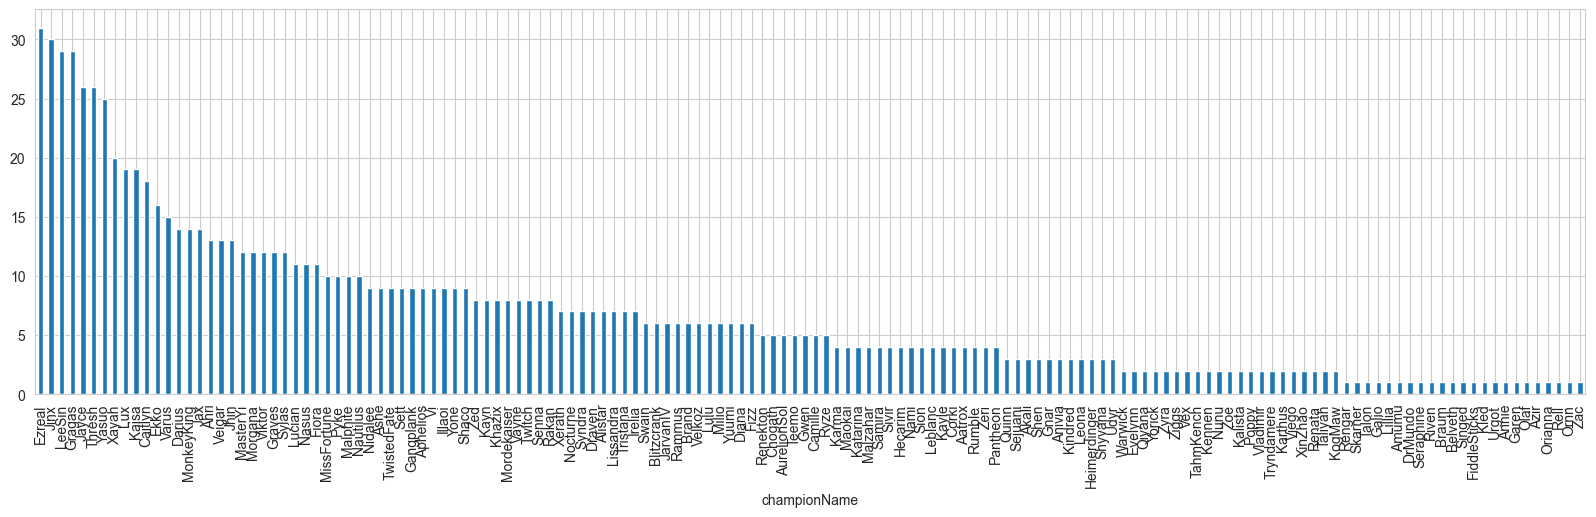

In [61]:
# những tướng được chơi nhiều nhất
df['championName'].value_counts().plot(kind='bar', figsize=(20,5))
len(df['championName'].unique())

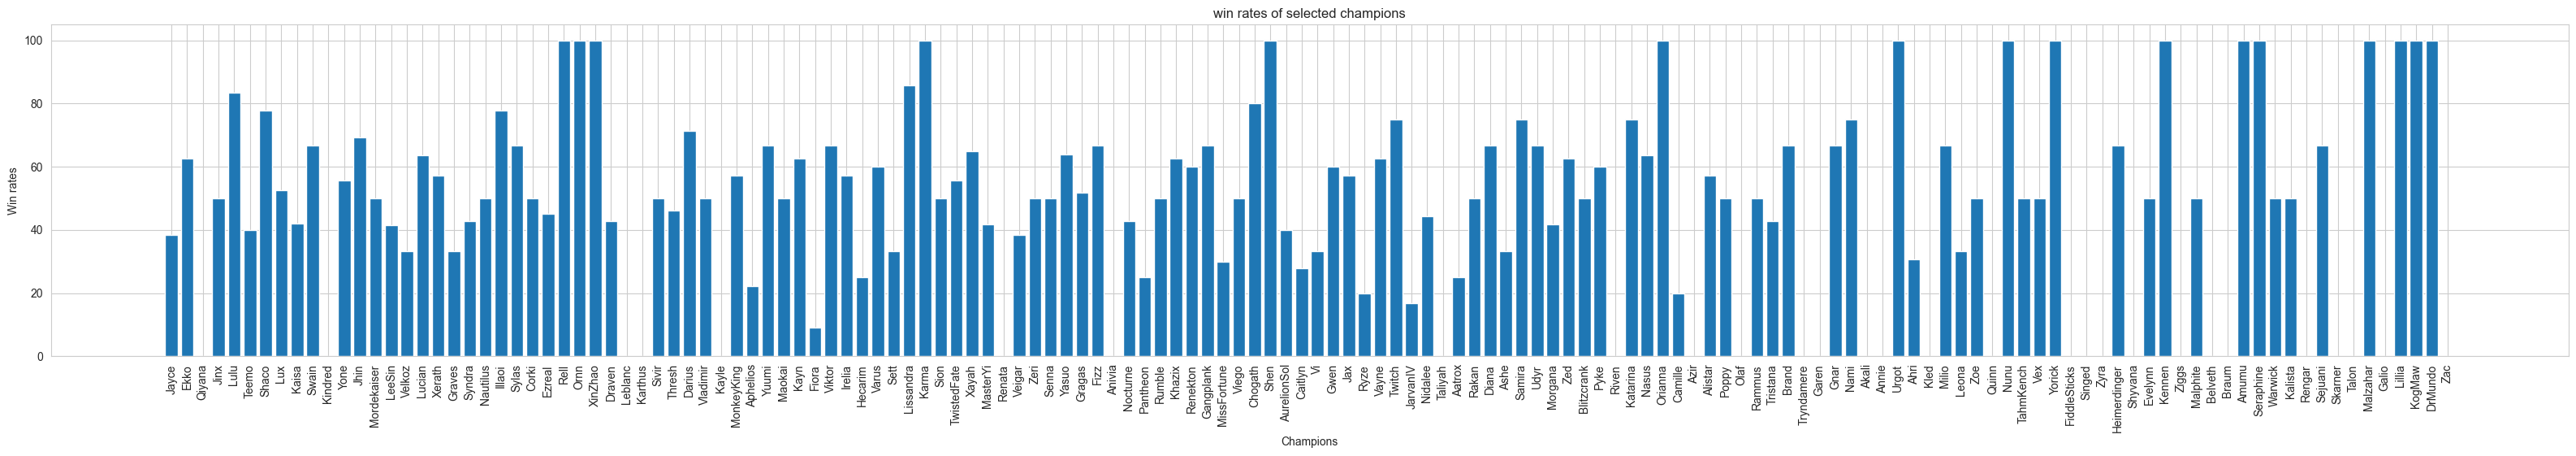

In [84]:
# tỉ lệ thắng của từng tướng
champ_arr = df['championName'].unique()
win_rates = [] 
for champ in champ_arr:
    win_rate = df.loc[(df['championName']==champ) &(df['win']==True)].shape[0]*100/df.loc[(df['championName']==champ)].shape[0]
    win_rates += [win_rate]
fig = plt.figure(figsize=(40,6))
plt.bar(champ_arr, win_rates)
plt.xlabel('Champions')
plt.ylabel('Win rates')
plt.title('win rates of selected champions')
plt.xticks(rotation=90)
plt.subplots_adjust(bottom=0.2)
plt.show()

In [52]:
def plot_boxplots(data, ncols = 4, figsize=(20,150)):
    nplots = data.shape[1]
    nrows = (nplots-1)//ncols + 1
    
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    
    for i, col in enumerate(data.columns):
        row = i//ncols
        col = i%ncols 
        axes[row, col].boxplot(data[col])
        axes[row, col].set_title(col)
        axes[row, col].set_ylabel('Giá trị')
    plt.tight_layout()
    plt.show()

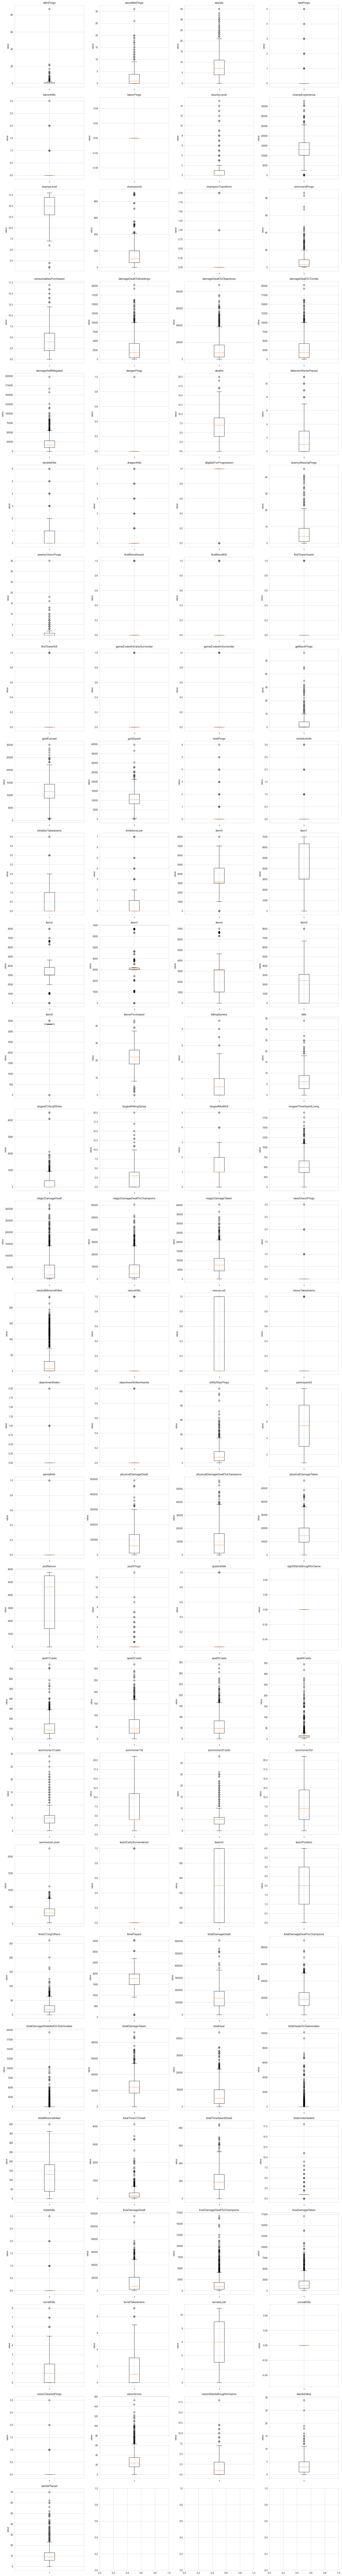

In [54]:
fig, axes = plt.subplots(nrows=28, ncols=4, figsize=(20, 150))
for i, col in enumerate(X.columns):
    axes[i//4, i%4].boxplot(X[col])
    axes[i//4, i%4].set_title(col)
    axes[i//4, i%4].set_ylabel('value')
plt.tight_layout()
plt.show()